# Takeaway
- Best practices:
    + use vmap
    + use lax.while_loop
    + write correct vectorized code
    + be sure to jit w/ with the correct static_argnums

In [27]:
import jax
import jax.numpy as jnp
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import time

In [28]:
%config InlineBackend.figure_format = 'svg'

In [29]:
jax.config.update("jax_enable_x64", True)

In [30]:
def create_model(
    R=1.01,
    beta=0.98,
    gamma=2,
    w_min=0.01,
    w_max=5,
    w_size=150,
    rho=0.9,
    nu=0.1,
    y_size=100,
):
    w_grid = np.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=rho, sigma=nu)
    y_grid, Q = np.exp(mc.state_values), mc.P
    params = (beta, R, gamma)
    sizes = (w_size, y_size)
    arrays = (w_grid, y_grid, Q)
    return params, sizes, arrays

we let state + action be `(w,y,wp)`

In [31]:
def B(v, model):
    params, sizes, arrays = model
    beta, R, gamma = params
    w_grid, y_grid, Q = arrays
    w_size, y_size = sizes

    w = np.reshape(w_grid, (w_size, 1, 1))
    y = np.reshape(y_grid, (1, y_size, 1))
    wp = np.reshape(w_grid, (1, 1, w_size))
    c = R * w + y - wp

    # v[w,y,wp,yp]
    v = np.reshape(v, (1, 1, w_size, y_size))
    Q = np.reshape(Q, (1, y_size, 1, y_size))
    EV = np.sum(v * Q, axis=3)

    ans = np.where(c > 0, c ** (-gamma) / (1 - gamma) + beta * EV, -np.inf)
    return ans

In [32]:
def T(v, model):
    return np.max(B(v, model), axis=2)


def get_greedy(v, model):
    return np.argmax(B(v, model), axis=2)

In [33]:
def VFI(model, max_iter=10000, tol=1e-8):
    params, sizes, arrays = model
    v = np.zeros(sizes)
    for i in range(max_iter):
        vp = T(v, model)
        err = np.max(np.abs(vp - v))
        if err < tol:
            print(f"Converged in {i} iterations")
            break

        if i % 100 == 0:
            print(f"Iteration {i}: error = {err}")
        v = vp
    wp = get_greedy(v, model)
    return v, wp

In [34]:
model = create_model()
start_time = time.time()
v, wp = VFI(model)
end_time = time.time()
numpy_time = end_time - start_time
print(f"Time taken: {numpy_time} seconds")

Iteration 0: error = 3.9594154392756313
Iteration 100: error = 0.13882976629631116
Iteration 200: error = 0.018375627917436077
Iteration 300: error = 0.0024369408530873216
Iteration 400: error = 0.0003231859935368675
Iteration 500: error = 4.2860782947684584e-05
Iteration 600: error = 5.684178027820508e-06
Iteration 700: error = 7.538331914247465e-07
Iteration 800: error = 9.997305028264236e-08
Iteration 900: error = 1.3258407705052377e-08
Converged in 914 iterations
Time taken: 15.734936237335205 seconds


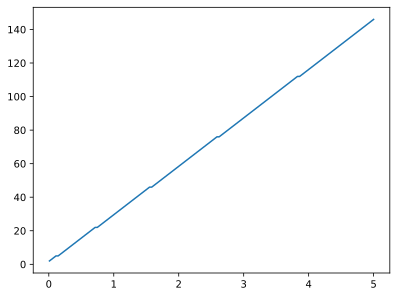

In [35]:
params, sizes, arrays = model
w_grid, y_grid, Q = arrays
w_size, y_size = sizes
y_index = jnp.floor(y_size / 2).astype(int)
plt.plot(w_grid, wp[:, y_index])
plt.show()

In [ ]:
def create_model_jax(
    R=1.01,
    beta=0.98,
    gamma=2,
    w_min=0.01,
    w_max=5,
    w_size=150,
    rho=0.9,
    nu=0.1,
    y_size=100,
):
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=rho, sigma=nu)
    y_grid, Q = jnp.exp(mc.state_values), jax.device_put(mc.P)
    params = (beta, R, gamma)
    sizes = (w_size, y_size)
    arrays = (w_grid, y_grid, Q)
    return params, sizes, arrays

In [37]:
def B(v, params, sizes, arrays, i, j, ip):
    """
    B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)
    The indices are (i, j, ip) -> (w, y, w′).
    """
    beta, R, gamma = params
    w_grid, y_grid, Q = arrays
    w_size, y_size = sizes
    w, y, wp = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    EV = jnp.sum(v[ip, :] * Q[j, :])
    ans = jnp.where(c > 0, c ** (-gamma) / (1 - gamma) + beta * EV, -jnp.inf)
    return ans

In [38]:
B_1 = jax.vmap(B, in_axes=(None, None, None, None, None, None, 0))
B_2 = jax.vmap(B_1, in_axes=(None, None, None, None, None, 0, None))
B_vmap = jax.vmap(B_2, in_axes=(None, None, None, None, 0, None, None))

In [39]:
def T_vmap(v, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices = jnp.arange(w_size)
    y_indices = jnp.arange(y_size)
    B_values = B_vmap(v, params, sizes, arrays, w_indices, y_indices, w_indices)
    return jnp.max(B_values, axis=-1)


T_vmap = jax.jit(T_vmap, static_argnums=(2,))


def get_greedy_vmap(v, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices = jnp.arange(w_size)
    y_indices = jnp.arange(y_size)
    B_values = B_vmap(v, params, sizes, arrays, w_indices, y_indices, w_indices)
    return jnp.argmax(B_values, axis=-1)


get_greedy_vmap = jax.jit(get_greedy_vmap, static_argnums=(2,))

In [40]:
def VFI_jax(params, sizes, arrays, max_iter=10000, tol=1e-8):
    v = jnp.zeros(sizes)
    for i in range(max_iter):
        vp = T_vmap(v, params, sizes, arrays)
        err = jnp.max(jnp.abs(vp - v))
        if err < tol:
            print(f"Converged in {i} iterations")
            break

        if i % 100 == 0:
            print(f"Iteration {i}: error = {err}")
        v = vp
    wp = get_greedy_vmap(v, params, sizes, arrays)
    return v, wp

In [41]:
params, sizes, arrays = create_model_jax()
v_jax, wp_jax = VFI_jax(params, sizes, arrays)

Iteration 0: error = 3.9594154392756313
Iteration 100: error = 0.13882976629632537
Iteration 200: error = 0.018375627917436077
Iteration 300: error = 0.0024369408531015324
Iteration 400: error = 0.0003231859935652892
Iteration 500: error = 4.2860782969000866e-05
Iteration 600: error = 5.6841780420313626e-06
Iteration 700: error = 7.538332056356012e-07
Iteration 800: error = 9.997307870435179e-08
Iteration 900: error = 1.325842902133445e-08
Converged in 914 iterations


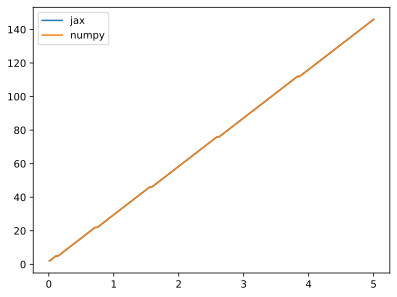

In [42]:
w_size, y_size = sizes
y_index = jnp.floor(y_size / 2).astype(int)
plt.plot(w_grid, wp_jax[:, y_index])
plt.plot(w_grid, wp[:, y_index])
plt.legend(["jax", "numpy"])
plt.show()

In [43]:
def B_jnp(v, params, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack
    β, R, γ = params
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w = jnp.reshape(w_grid, (w_size, 1, 1))  # w[i]   ->  w[i, j, ip]
    y = jnp.reshape(y_grid, (1, y_size, 1))  # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))  # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)  # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, c ** (1 - γ) / (1 - γ) + β * EV, -jnp.inf)


B_jnp = jax.jit(B_jnp, static_argnums=(2,))

In [44]:
def T_jnp(v, params, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B_jnp(v, params, sizes, arrays), axis=2)


T_jnp = jax.jit(T_jnp, static_argnums=(2,))

In [45]:
def get_greedy_jnp(v, params, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B_jnp(v, params, sizes, arrays), axis=2)


get_greedy_jnp = jax.jit(get_greedy_jnp, static_argnums=(2,))

In [46]:
def VFI_jnp(params, sizes, arrays, max_iter=10000, tol=1e-8):
    v = jnp.zeros(sizes)
    for i in range(max_iter):
        vp = T_jnp(v, params, sizes, arrays)
        err = jnp.max(jnp.abs(vp - v))
        if err < tol:
            print(f"Converged in {i} iterations")
            break

        if i % 100 == 0:
            print(f"Iteration {i}: error = {err}")
        v = vp
    wp = get_greedy_jnp(v, params, sizes, arrays)
    return v, wp

In [47]:
%time v_jnp, wp_jnp = VFI_jnp(params, sizes, arrays)

Iteration 0: error = 1.9898279923841737
Iteration 100: error = 0.1341602828886863
Iteration 200: error = 0.01778651948564658
Iteration 300: error = 0.0023588382542314434
Iteration 400: error = 0.00031282808098609394
Iteration 500: error = 4.1487121215766365e-05
Iteration 600: error = 5.50200363136355e-06
Iteration 700: error = 7.296733244288589e-07
Iteration 800: error = 9.676899992427934e-08
Iteration 900: error = 1.2833503149067838e-08
Converged in 913 iterations
CPU times: user 12.9 s, sys: 1.12 s, total: 14 s
Wall time: 3.65 s


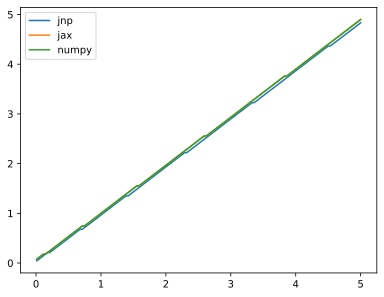

In [48]:
plt.plot(w_grid, w_grid[wp_jnp[:, y_index]])
plt.plot(w_grid, w_grid[wp_jax[:, y_index]])
plt.plot(w_grid, w_grid[wp[:, y_index]])
plt.legend(["jnp", "jax", "numpy"])
plt.show()

In [49]:
def successive_approx_jax(T, x_0, tol=1e-8, max_iter=10_000):
    def body_fun(k_x_err):
        k, x, err = k_x_err
        x_new = T(x)
        err = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, err

    def cond_fun(k_x_err):
        k, x, err = k_x_err
        return jnp.logical_and(k < max_iter, err > tol)

    k, x, err = jax.lax.while_loop(
        cond_fun,
        body_fun,
        (1, x_0, jnp.inf),
    )
    return x


successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(0,))

In [50]:
def VFI_lax(params, sizes, arrays):
    v_0 = jnp.zeros(sizes)
    _T = lambda v: T_vmap(v, params, sizes, arrays)
    v = successive_approx_jax(_T, v_0)
    return v, get_greedy_vmap(v, params, sizes, arrays)

In [51]:
%time v_lax, wp_lax = VFI_lax(params, sizes, arrays)

CPU times: user 186 ms, sys: 7.44 ms, total: 193 ms
Wall time: 60 ms


In [52]:
start_time = time.time()
v_lax, wp_lax = VFI_lax(params, sizes, arrays)
end_time = time.time()
lax_time = end_time - start_time
print(f"Time taken: {lax_time} seconds")

print(f"Speedup: {numpy_time / lax_time}")

Time taken: 0.05189394950866699 seconds
Speedup: 303.2133107291681
